# Important note: when we have to do up operation we have to check if we are in ladder area, if we do then execute this operation 20 frames, so agent can climb ladder.
Remove irrelvant actions. relevant actions are: Actions Likely Useful:

0 NOOP
1 FIRE (Jump)
2 UP (Climb Up)
3 RIGHT (Move Right)
4 LEFT (Move Left)
5 DOWN (Climb Down)
11 RIGHTFIRE (Jump while moving right)
12 LEFTFIRE (Jump while moving left)

In [11]:
import gymnasium as gym
import cv2
import numpy as np
import os

In [403]:
import warnings
warnings.filterwarnings('ignore')
import ale_py
import gymnasium as gym
from stable_baselines3 import DQN
from stable_baselines3.common.vec_env import DummyVecEnv, VecFrameStack, VecTransposeImage
from stable_baselines3.common.atari_wrappers import MaxAndSkipEnv
import torch
import numpy as np
import wandb
from wandb.integration.sb3 import WandbCallback
from gymnasium.wrappers import ResizeObservation
print(gym.__version__)
from stable_baselines3.common.monitor import Monitor
import matplotlib.pyplot as plt
import os
from stable_baselines3 import DQN
from stable_baselines3.common.callbacks import CheckpointCallback
from datetime import datetime
from stable_baselines3 import A2C
from stable_baselines3.ppo.policies import MlpPolicy
from wandb.integration.sb3 import WandbCallback
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import EvalCallback, CallbackList
import collections
from stable_baselines3.common.callbacks import BaseCallback
import torch
from stable_baselines3.common.vec_env import VecEnvWrapper
from gymnasium.spaces import Discrete

1.0.0


In [10]:
gym.register_envs(ale_py)

In [ ]:
# configuration file
config = {
    "policy_type": "CnnPolicy",
    "total_timesteps": 30000000, # 1000000, 3000000, 20000000
    "Algo": "PPO",
    "env_name": "ALE/DonkeyKong-v5",
    "model_name": "ALE/DonkeyKong-v5",
    "export_path": "/kaggle/working/exports/",
    "videos_path": "/kaggle/working/videos/",
}

In [14]:
class MyVecTransposeImage(VecEnvWrapper):
    def __init__(self, venv, skip=False):
        super().__init__(venv)
        self.skip = skip

        # Get original shape: e.g., (84, 84, 4)
        old_shape = self.observation_space.shape
        # Transpose shape to (C, H, W)
        new_shape = (old_shape[2], old_shape[0], old_shape[1])  # (4, 84, 84)

        # Use the original low/high if they are uniform; if not, use min/max appropriately
        low_val = self.observation_space.low.min()
        high_val = self.observation_space.high.max()

        self.observation_space = gym.spaces.Box(
            low=low_val,
            high=high_val,
            shape=new_shape,
            dtype=self.observation_space.dtype
        )

    def reset(self):
        obs = self.venv.reset()
        return self.transpose_observations(obs)

    def step_async(self, actions):
        self.venv.step_async(actions)

    def step_wait(self):
        obs, rewards, dones, infos = self.venv.step_wait()
        return self.transpose_observations(obs), rewards, dones, infos

    def transpose_observations(self, obs):
        if self.skip:
            return obs
        if isinstance(obs, dict):
            for key, val in obs.items():
                obs[key] = self._transpose(val)
            return obs
        else:
            return self._transpose(obs)

    def _transpose(self, obs):
        # obs shape is (n_envs, H, W, C) -> transpose to (n_envs, C, H, W)
        return obs.transpose(0, 3, 1, 2)


In [393]:
def get_agent_level_position(image):
    if image is None:
        raise ValueError("Image not loaded. Check the path and file.")
    
    # remove 0 to 25 pixels from the top
    image = image[32:, :]
    # plt.imshow(image, cmap='gray')

    image[149:160, 36:44] = 0
    # display image with black
    # plt.imshow(image, cmap='gray')

    # Lines detection
    # copy image
    gray_image = image.copy()

    # print("Image shape:", gray_image.shape)

    # Perform edge detection
    edges = cv2.Canny(gray_image, threshold1=30, threshold2=100)

    # Debug: Show edges
    # plt.figure(figsize=(6, 4))
    # plt.imshow(edges, cmap='gray')
    # plt.title("Edges")
    # plt.axis("off")
    # plt.show()

    # Detect horizontal lines using Hough Transform
    lines = cv2.HoughLinesP(
        edges, 
        rho=1, 
        theta=np.pi / 180, 
        threshold=30, 
        minLineLength=10, 
        maxLineGap=20
    )

    # Draw detected lines on a debug image
    debug_line_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    horizontal_lines = []

    if lines is not None:
        # print(f"Total lines detected (before filtering): {len(lines)}")
        for line in lines:
            x1, y1, x2, y2 = line[0]
            # Check for horizontal lines with a more lenient threshold
            vertical_diff = abs(y2 - y1)
            horizontal_diff = abs(x2 - x1)
            
            if vertical_diff < horizontal_diff * 0.1:  # Allow slight vertical tilt
                horizontal_lines.append((x1, y1, x2, y2))
                # cv2.line(debug_line_image, (x1, y1), (x2, y2), (255, 0, 0), 2)  # Blue for horizontal lines
    else:
        print("No lines detected.")

    # Debug: Show all detected horizontal lines
    # plt.figure(figsize=(10, 6))
    # plt.imshow(cv2.cvtColor(debug_line_image, cv2.COLOR_BGR2RGB))
    # plt.title("Detected Horizontal Lines (Blue)")
    # plt.axis("off")
    # plt.show()

    # Print detected horizontal lines for debugging
    # print(f"Total horizontal lines detected (after filtering): {len(horizontal_lines)}")
    # for idx, (x1, y1, x2, y2) in enumerate(horizontal_lines):
    #     print(f"Line {idx + 1}: ({x1}, {y1}) to ({x2}, {y2})")

    # detect the agent and it position
    # Perform binary thresholding to highlight the agent and objects
    _, binary = cv2.threshold(gray_image, 50, 255, cv2.THRESH_BINARY)

    # Apply morphological operations to clean up noise
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    binary_cleaned = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)

    # Debug: Show the binary image after cleaning
    # plt.figure(figsize=(6, 4))
    # plt.imshow(binary_cleaned, cmap='gray')
    # plt.title("Binary Image (Cleaned)")
    # plt.axis("off")
    # plt.show()

    # Detect contours in the cleaned binary image
    contours, _ = cv2.findContours(binary_cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Initialize variables for the agent's position
    agent_detection_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    agent_position = None

    # Filter contours to find the agent
    # print(f"Total contours detected: {len(contours)}")

    for contour in contours:
        # Get bounding box of the contour
        x, y, w, h = cv2.boundingRect(contour)
        
        # Filter based on size: Assuming agent is small
        if 5 <= w <= 30 and 5 <= h <= 30:  # Adjust range based on resolution
            # Further filter based on aspect ratio to avoid line-like objects
            aspect_ratio = max(w / h, h / w)
            if aspect_ratio < 2.0:  # Allow only nearly square contours
                agent_position = (x + w // 2, y + h // 2)  # Center of the bounding box
                
                # Draw the bounding box and center point for the agent
                # cv2.rectangle(agent_detection_image, (x, y), (x + w, y + h), (0, 255, 0), 2)
                # cv2.circle(agent_detection_image, agent_position, radius=5, color=(0, 0, 255), thickness=-1)
                # print(f"Agent detected at: {agent_position}, size: {w}x{h}")
                break  # Assuming only one agent in the frame

    if agent_position is None:
        print("No agent detected. Try adjusting size and aspect ratio filters.")

    # Display the agent detection result
    # plt.figure(figsize=(10, 6))
    # plt.imshow(cv2.cvtColor(agent_detection_image, cv2.COLOR_BGR2RGB))
    # plt.title("Agent Detection")
    # plt.axis("off")
    # plt.show()

    
    # Detect level
    # Sort lines by their average y-value, descending (bottom to top)
    lines_sorted = sorted(horizontal_lines, key=lambda line: (line[1] + line[3]) / 2, reverse=True)

    def cluster_lines(lines, desired_clusters=7, proximity_threshold=10):
        clusters = []
        current_cluster = [lines[0]]
        for line in lines[1:]:
            line_y = (line[1] + line[3]) // 2
            current_cluster_y = sum((l[1]+l[3])//2 for l in current_cluster) / len(current_cluster)
            # If the difference is small, add to current cluster, else start a new one
            if abs(line_y - current_cluster_y) < proximity_threshold:
                current_cluster.append(line)
            else:
                clusters.append(current_cluster)
                current_cluster = [line]
        clusters.append(current_cluster)
        
        # If we get more or fewer than desired_clusters, adjust proximity_threshold and try again
        # For simplicity, if we don't get exactly 7, we might raise an error or adjust threshold.
        # But here we assume we pick a threshold that works.
        if len(clusters) != desired_clusters:
            # Adjust proximity_threshold manually or implement a loop to find a suitable threshold.
            print(f"Expected {desired_clusters} clusters, got {len(clusters)}. Adjust proximity_threshold.")
        return clusters

    proximity_threshold = 10  # Adjust as needed
    clusters = cluster_lines(lines_sorted, desired_clusters=7, proximity_threshold=proximity_threshold)

    # Compute representative y-value for each cluster (average)
    boundary_y_values = []
    for cluster in clusters:
        avg_y = sum((l[1] + l[3]) // 2 for l in cluster) / len(cluster)
        boundary_y_values.append(avg_y)

    # Sort boundaries again in descending order (bottom = largest y, top = smallest y)
    boundary_y_values.sort(reverse=True)

    # Now we have 7 boundaries for 6 levels:
    # Level 1: between boundary_y_values[0] and boundary_y_values[1]
    # Level 2: between boundary_y_values[1] and boundary_y_values[2]
    # ...
    # Level 6: between boundary_y_values[5] and boundary_y_values[6]

    agent_level = None
    if agent_position:
        agent_y = agent_position[1]
        # Find which level agent_y falls into
        for i in range(6):
            if boundary_y_values[i] >= agent_y > boundary_y_values[i+1]:
                agent_level = i + 1
                break

    # Print only the agent's level
    # if agent_level is not None:
    #     print(agent_level)
    # else:
    #     print("Could not determine agent's level.")
    if agent_level is None:
        print("Could not determine agent's level.")

    # Draw minimal annotation: just draw the agent and print its level
    final_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    # if agent_position:
    #     cv2.circle(final_image, agent_position, radius=5, color=(0, 0, 255), thickness=-1)
    #     if agent_level is not None:
    #         cv2.putText(
    #             final_image, 
    #             f"Level: {agent_level}", 
    #             (agent_position[0] + 10, agent_position[1] - 10), 
    #             cv2.FONT_HERSHEY_SIMPLEX, 
    #             0.5, 
    #             (0, 255, 0), 
    #             1
    #         )

    # plt.figure(figsize=(10, 6))
    # plt.imshow(cv2.cvtColor(final_image, cv2.COLOR_BGR2RGB))
    # plt.axis("off")
    # plt.show()

    return agent_level, agent_position # agent position is (x, y)

        y-axis    x-axis
Level 1: 149:160, (108:112 = 110)

Level 2: 115:136, (80:84 = 82)

Level 3: 87:107, (88:92 = 90)

Level 4: 59:79, (68:72 = 70)

Level 5: 33:50, (108:112 = 110)

Level 6: 6:27, (76:80 = 78) 

In [424]:
class IntermediateRewardWrapper(gym.Wrapper):
    def __init__(self, env):
        super(IntermediateRewardWrapper, self).__init__(env)
        self.ladder_postion = [110,82,90,70,110,78]
        self.last_level = 1
        self.previous_additional_reward = 0.0

    def step(self, action):

        obs, reward, terminated, truncated, info = self.env.step(action)
        print(obs.shape)
        # done = terminated or truncated

        additional_reward = 0.0
        # get agent level and position
        agent_level, agent_position = get_agent_level_position(obs)

        


        if agent_level is not None and 1 <= agent_level <= len(self.ladder_postion):
            agent_level_reward = (7 - agent_level)* (-0.01)
            additional_reward += agent_level_reward
            
            if agent_level > self.last_level:
                additional_reward += 1000.0
                self.last_level = agent_level

            diff = 0
            if agent_position is not None and len(agent_position) > 0:
                # get absolute difference between agent position and ladder position
                diff = abs(self.ladder_postion[agent_level - 1] - agent_position[0])
                agent_position_reward = diff * (-0.1)
                additional_reward += agent_position_reward 
            
            # if action == 2:
            #     if diff <= 6:
            #         for i in range(30):
            #             obs, reward, terminated, truncated, info = self.env.step(2)
            #             if terminated or truncated:
            #                 break


        else:
            # If agent_level or agent_position not found, use the previous reward
            additional_reward = self.previous_additional_reward


        # Round the additional reward to 2 decimal places
        additional_reward = round(additional_reward, 2)

        # Update the previous reward
        self.previous_additional_reward = additional_reward

        # Add the additional reward to the original reward
        reward += additional_reward

        # print(f"obs: {obs.shape} , Agent Level: {agent_level}, Agent Position: {agent_position}, Additional Reward: {additional_reward}, Total Reward: {reward}")
        
        return obs, reward, terminated, truncated, info


In [425]:
class ActionFilterWrapper(gym.ActionWrapper):
    def __init__(self, env, allowed_actions):
        super().__init__(env)
        self.allowed_actions = allowed_actions
        # The new action space matches the number of allowed actions
        self.action_space = Discrete(len(self.allowed_actions))

    def action(self, act):
        # Map the reduced action space index to the original action
        return self.allowed_actions[act]

In [428]:
class ScaledFloatFrame(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        # The original shape remains (84,84,1), but the dtype and range change
        self.observation_space = gym.spaces.Box(
            low=0.0,
            high=1.0,
            shape=self.observation_space.shape,
            dtype=np.float32
        )
        
    def observation(self, obs):
        return np.array(obs).astype(np.float32) / 255.0



class FireResetEnv(gym.Wrapper):
    def __init__(self, env=None):
        super().__init__(env)
        # Check that 'FIRE' is a valid action in the environment
        assert 'FIRE' in env.unwrapped.get_action_meanings(), "Environment does not support 'FIRE' action"
        assert len(env.unwrapped.get_action_meanings()) >= 3, "Action space too small for expected actions"

    def step(self, action):
        return self.env.step(action)

    def reset(self, **kwargs):
        # Reset the environment
        obs, info = self.env.reset(**kwargs)

        # Perform the FIRE action
        obs, _, terminated, truncated, _ = self.env.step(1)
        if terminated or truncated:  # If game ends after FIRE, reset again
            obs, info = self.env.reset(**kwargs)

        return obs, info
        
# Custom wrapper to add channel dimension
class AddChannelDimension(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        obs_shape = self.observation_space.shape
        # Update the observation space to include a channel dimension
        self.observation_space = gym.spaces.Box(
            low=0,
            high=255,
            shape=(obs_shape[0], obs_shape[1], 1),
            dtype=np.uint8,
        )

    def observation(self, observation):
        # Add a channel dimension
        return np.expand_dims(observation, axis=-1)



def make_env(env_name, allowed_actions, obs_type="grayscale", render_mode=None):
    def _init():
        env = gym.make(env_name, obs_type="grayscale", render_mode=render_mode)
        print("Standard Env.        : {}".format(env.observation_space.shape))
        env = FireResetEnv(env)
        print("FireResetEnv          : {}".format(env.observation_space.shape))
        # Wrap the environment with the custom ActionFilterWrapper
        env = ActionFilterWrapper(env, allowed_actions)

        # Wrap the environment to add intermediate rewards
        env = IntermediateRewardWrapper(env)
        print("IntermediateReward    : {}".format(env.observation_space.shape))
        env = ResizeObservation(env, (84, 84))
        print("ResizeObservation    : {}".format(env.observation_space.shape))
        env = AddChannelDimension(env)  # Add channel dimension here
        print("AddChannelDimension  : {}".format(env.observation_space.shape))
        
        env = ScaledFloatFrame(env)
        print("ScaledFloatFrame     : {}".format(env.observation_space.shape))
        

        return env
    return _init

# select relevant actions
allowed_actions = [0, 1, 2, 3, 4, 5, 11, 12]


# env = DummyVecEnv([make_env(config["env_name"])])
# use make_vec_env with n_envs=16
env = make_vec_env(env_id=make_env(config["env_name"], allowed_actions= allowed_actions, render_mode='rgb_array'), n_envs=8)

# # stack 4 frames
# env = VecFrameStack(env, n_stack=4)
# print("Post VecFrameStack Shape: {}".format(env.observation_space.shape))

# convert back to PyTorch format (channel-first)
# env = VecTransposeImage(env)
env = MyVecTransposeImage(env)
print("VecTransposeImage Shape: {}".format(env.observation_space.shape))

print("Final Observation Space: {}".format(env.observation_space.shape))

Standard Env.        : (210, 160)
FireResetEnv          : (210, 160)
IntermediateReward    : (210, 160)
ResizeObservation    : (84, 84)
AddChannelDimension  : (84, 84, 1)
ScaledFloatFrame     : (84, 84, 1)
Standard Env.        : (210, 160)
FireResetEnv          : (210, 160)
IntermediateReward    : (210, 160)
ResizeObservation    : (84, 84)
AddChannelDimension  : (84, 84, 1)
ScaledFloatFrame     : (84, 84, 1)
Standard Env.        : (210, 160)
FireResetEnv          : (210, 160)
IntermediateReward    : (210, 160)
ResizeObservation    : (84, 84)
AddChannelDimension  : (84, 84, 1)
ScaledFloatFrame     : (84, 84, 1)
Standard Env.        : (210, 160)
FireResetEnv          : (210, 160)
IntermediateReward    : (210, 160)
ResizeObservation    : (84, 84)
AddChannelDimension  : (84, 84, 1)
ScaledFloatFrame     : (84, 84, 1)
Standard Env.        : (210, 160)
FireResetEnv          : (210, 160)
IntermediateReward    : (210, 160)
ResizeObservation    : (84, 84)
AddChannelDimension  : (84, 84, 1)
Scale

# I am here, i am try with multiple environments and after stacking using VecFrameStack

In [432]:
obs = env.reset()

frame_count = 0

# Create a directory to store frames
os.makedirs('C:/Users/amrit/Escriptori/Uni/3r/Paradigmes de aprentage automatic/obs_frames', exist_ok=True)

save_image = 0
# Run the environment and capture observations
action = 3
for _ in range(10):  # Adjust the range for the desired number of frames
    print(action)
    obs, reward, done, info = env.step([action])  # Perform the action
    # print(reward)

    # if save_image % 10 == 0:
    # Remove the batch dimension and scale back to [0, 255]
    obs_image = (obs[0].squeeze() * 255).astype(np.uint8)  # Ensure it's a 2D array

    # Save the observation as a grayscale image
    frame_path = f'C:/Users/amrit/Escriptori/Uni/3r/Paradigmes de aprentage automatic/obs_frames/frame_{frame_count:04d}.png'
    # print(f"Saving {frame_path} with shape {obs_image.shape}")
    cv2.imwrite(frame_path, obs_image)
    frame_count += 1


    save_image += 1
    if done:
        print("Episode done.")
        obs = env.reset()  # Reset the environment if done

env.close()
print("Grayscale observations saved.")


3
(210, 160)


IndexError: list index out of range

In [427]:
obs = env.reset()

frame_count = 0

# Create a directory to store frames
os.makedirs('C:/Users/amrit/Escriptori/Uni/3r/Paradigmes de aprentage automatic/obs_frames', exist_ok=True)

save_image = 0
# Run the environment and capture observations
action = 3
for _ in range(200):  # Adjust the range for the desired number of frames
    obs, reward, done, info = env.step([action])  # Perform the action
    # print(reward)

    # if save_image % 10 == 0:
    # Remove the batch dimension and scale back to [0, 255]
    obs_image = (obs[0].squeeze() * 255).astype(np.uint8)  # Ensure it's a 2D array

    # Save the observation as a grayscale image
    frame_path = f'C:/Users/amrit/Escriptori/Uni/3r/Paradigmes de aprentage automatic/obs_frames/frame_{frame_count:04d}.png'
    # print(f"Saving {frame_path} with shape {obs_image.shape}")
    cv2.imwrite(frame_path, obs_image)
    frame_count += 1


    if save_image == 52:
        action = 2

    if save_image == 82:
        action = 4
    
    if save_image == 103:
        action = 2

    if save_image == 133:
        action = 3

    if save_image == 140:
        action = 2

    save_image += 1
    if done:
        print("Episode done.")
        obs = env.reset()  # Reset the environment if done

env.close()
print("Grayscale observations saved.")


(210, 160)
(210, 160)
(210, 160)
(210, 160)
(210, 160)
(210, 160)
(210, 160)
(210, 160)
(210, 160)
(210, 160)
(210, 160)
(210, 160)
(210, 160)
(210, 160)
(210, 160)
(210, 160)
(210, 160)
(210, 160)
(210, 160)
(210, 160)
(210, 160)
(210, 160)
(210, 160)
(210, 160)
(210, 160)
(210, 160)
(210, 160)
(210, 160)
(210, 160)
(210, 160)
(210, 160)
(210, 160)
(210, 160)
(210, 160)
(210, 160)
(210, 160)
(210, 160)
(210, 160)
(210, 160)
(210, 160)
(210, 160)
(210, 160)
(210, 160)
(210, 160)
(210, 160)
Expected 7 clusters, got 6. Adjust proximity_threshold.
(210, 160)
(210, 160)
(210, 160)
(210, 160)
(210, 160)
(210, 160)
(210, 160)
(210, 160)
(210, 160)
No agent detected. Try adjusting size and aspect ratio filters.
Could not determine agent's level.
(210, 160)
(210, 160)
(210, 160)
(210, 160)
(210, 160)
(210, 160)
(210, 160)
(210, 160)
(210, 160)
(210, 160)
(210, 160)
(210, 160)
(210, 160)
(210, 160)
(210, 160)
(210, 160)
(210, 160)
(210, 160)
(210, 160)
(210, 160)
(210, 160)
(210, 160)
(210, 160

# Start analysis

In [161]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [389]:
get_agent_position_level(image)

(1, (48, 148))

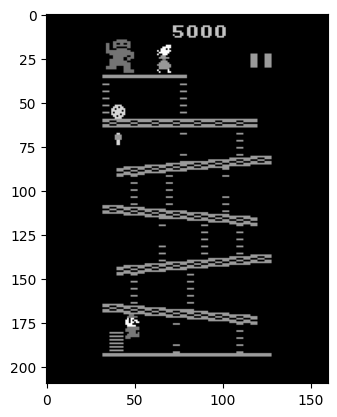

In [388]:
# read one image
image = cv2.imread('C:/Users/amrit/Escriptori/Uni/3r/Paradigmes de aprentage automatic/obs_frames/frame_0000.png', cv2.IMREAD_GRAYSCALE)
# display image
plt.imshow(image, cmap='gray')

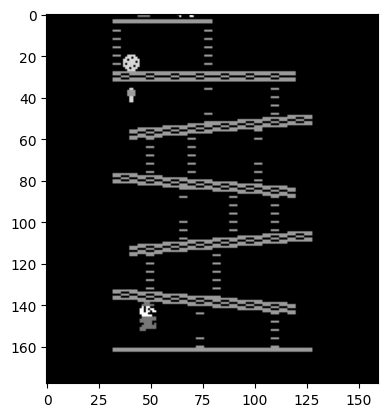

In [390]:
# # remove 0 to 25 pixels from the top
# copy image
image_prova = image.copy()
image_prova = image_prova[32:, :]
# # display cropped image
plt.imshow(image_prova, cmap='gray')

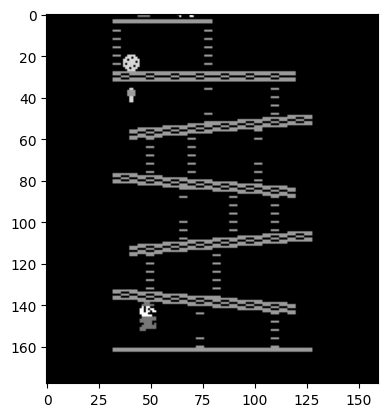

In [391]:
# add black value to x a 30-35 pixels and y a 145-150 pixels
# copy image
# image_with_black = image.copy()
# add black value to x a 30-35 pixels and y a 145-150 pixels
image_prova[149:160, 36:44] = 0
# display image with black
plt.imshow(image_prova, cmap='gray')

```Now we check positions of ladders of each level```

        y-axis    x-axis
Level 1: 149:160, (108:112 = 110)

Level 2: 115:136, (80:84 = 82)

Level 3: 87:107, (88:92 = 90)

Level 4: 59:79, (68:72 = 70)

Level 5: 33:50, (108:112 = 110)

Level 6: 6:27, (76:80 = 78) 

In [330]:
# # copy image
# image_check_level = image.copy()
# # add white value to x a 30-35 pixels and y a 145-150 pixels
# image_check_level[6:27, 76:80] = 255
# # display image with white
# plt.imshow(image_check_level, cmap='gray')

```End check position```

In [ ]:
# if image is None:
#     raise ValueError("Image not loaded. Check the path and file.")

# # Convert to grayscale if not already (Donkey Kong Atari frames might already be grayscale)
# if len(image.shape) == 3:
#     gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# else:
#     # Already grayscale
#     gray_image = image

# print("Image shape:", gray_image.shape)

# # Perform edge detection
# edges = cv2.Canny(gray_image, threshold1=30, threshold2=100)

# # Debug: Show edges
# plt.figure(figsize=(6, 4))
# plt.imshow(edges, cmap='gray')
# plt.title("Edges")
# plt.axis("off")
# plt.show()

# # Detect horizontal lines using Hough Transform
# lines = cv2.HoughLinesP(
#     edges, 
#     rho=1, 
#     theta=np.pi / 180, 
#     threshold=30, 
#     minLineLength=10, 
#     maxLineGap=20
# )

# # Draw detected lines on a debug image
# debug_line_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
# horizontal_lines = []

# if lines is not None:
#     print(f"Total lines detected (before filtering): {len(lines)}")
#     for line in lines:
#         x1, y1, x2, y2 = line[0]
#         # Check for horizontal lines with a more lenient threshold
#         vertical_diff = abs(y2 - y1)
#         horizontal_diff = abs(x2 - x1)
        
#         if vertical_diff < horizontal_diff * 0.1:  # Allow slight vertical tilt
#             horizontal_lines.append((x1, y1, x2, y2))
#             cv2.line(debug_line_image, (x1, y1), (x2, y2), (255, 0, 0), 2)  # Blue for horizontal lines
# else:
#     print("No lines detected.")

# # Debug: Show all detected horizontal lines
# plt.figure(figsize=(10, 6))
# plt.imshow(cv2.cvtColor(debug_line_image, cv2.COLOR_BGR2RGB))
# plt.title("Detected Horizontal Lines (Blue)")
# plt.axis("off")
# plt.show()

# # Print detected horizontal lines for debugging
# print(f"Total horizontal lines detected (after filtering): {len(horizontal_lines)}")
# for idx, (x1, y1, x2, y2) in enumerate(horizontal_lines):
#     print(f"Line {idx + 1}: ({x1}, {y1}) to ({x2}, {y2})")

In [364]:
# # Perform binary thresholding to highlight the agent and objects
# _, binary = cv2.threshold(gray_image, 50, 255, cv2.THRESH_BINARY)

# # Apply morphological operations to clean up noise
# kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
# binary_cleaned = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)

# # Debug: Show the binary image after cleaning
# plt.figure(figsize=(6, 4))
# plt.imshow(binary_cleaned, cmap='gray')
# plt.title("Binary Image (Cleaned)")
# plt.axis("off")
# plt.show()

# # Detect contours in the cleaned binary image
# contours, _ = cv2.findContours(binary_cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# # Initialize variables for the agent's position
# agent_detection_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
# agent_position = None

# # Filter contours to find the agent
# print(f"Total contours detected: {len(contours)}")

# for contour in contours:
#     # Get bounding box of the contour
#     x, y, w, h = cv2.boundingRect(contour)
    
#     # Filter based on size: Assuming agent is small
#     if 5 <= w <= 30 and 5 <= h <= 30:  # Adjust range based on resolution
#         # Further filter based on aspect ratio to avoid line-like objects
#         aspect_ratio = max(w / h, h / w)
#         if aspect_ratio < 2.0:  # Allow only nearly square contours
#             agent_position = (x + w // 2, y + h // 2)  # Center of the bounding box
            
#             # Draw the bounding box and center point for the agent
#             cv2.rectangle(agent_detection_image, (x, y), (x + w, y + h), (0, 255, 0), 2)
#             cv2.circle(agent_detection_image, agent_position, radius=5, color=(0, 0, 255), thickness=-1)
#             print(f"Agent detected at: {agent_position}, size: {w}x{h}")
#             break  # Assuming only one agent in the frame

# if agent_position is None:
#     print("No agent detected. Try adjusting size and aspect ratio filters.")

# # Display the agent detection result
# plt.figure(figsize=(10, 6))
# plt.imshow(cv2.cvtColor(agent_detection_image, cv2.COLOR_BGR2RGB))
# plt.title("Agent Detection")
# plt.axis("off")
# plt.show()


In [433]:
# # Sort lines by their average y-value, descending (bottom to top)
# lines_sorted = sorted(horizontal_lines, key=lambda line: (line[1] + line[3]) / 2, reverse=True)

# def cluster_lines(lines, desired_clusters=7, proximity_threshold=10):
#     clusters = []
#     current_cluster = [lines[0]]
#     for line in lines[1:]:
#         line_y = (line[1] + line[3]) // 2
#         current_cluster_y = sum((l[1]+l[3])//2 for l in current_cluster) / len(current_cluster)
#         # If the difference is small, add to current cluster, else start a new one
#         if abs(line_y - current_cluster_y) < proximity_threshold:
#             current_cluster.append(line)
#         else:
#             clusters.append(current_cluster)
#             current_cluster = [line]
#     clusters.append(current_cluster)
    
#     # If we get more or fewer than desired_clusters, adjust proximity_threshold and try again
#     # For simplicity, if we don't get exactly 7, we might raise an error or adjust threshold.
#     # But here we assume we pick a threshold that works.
#     if len(clusters) != desired_clusters:
#         # Adjust proximity_threshold manually or implement a loop to find a suitable threshold.
#         print(f"Expected {desired_clusters} clusters, got {len(clusters)}. Adjust proximity_threshold.")
#     return clusters

# proximity_threshold = 10  # Adjust as needed
# clusters = cluster_lines(lines_sorted, desired_clusters=7, proximity_threshold=proximity_threshold)

# # Compute representative y-value for each cluster (average)
# boundary_y_values = []
# for cluster in clusters:
#     avg_y = sum((l[1] + l[3]) // 2 for l in cluster) / len(cluster)
#     boundary_y_values.append(avg_y)

# # Sort boundaries again in descending order (bottom = largest y, top = smallest y)
# boundary_y_values.sort(reverse=True)

# # Now we have 7 boundaries for 6 levels:
# # Level 1: between boundary_y_values[0] and boundary_y_values[1]
# # Level 2: between boundary_y_values[1] and boundary_y_values[2]
# # ...
# # Level 6: between boundary_y_values[5] and boundary_y_values[6]

# agent_level = None
# if agent_position:
#     agent_y = agent_position[1]
#     # Find which level agent_y falls into
#     for i in range(6):
#         if boundary_y_values[i] >= agent_y > boundary_y_values[i+1]:
#             agent_level = i + 1
#             break

# # Print only the agent's level
# if agent_level is not None:
#     print(agent_level)
# else:
#     print("Could not determine agent's level.")

# # Draw minimal annotation: just draw the agent and print its level
# final_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
# if agent_position:
#     cv2.circle(final_image, agent_position, radius=5, color=(0, 0, 255), thickness=-1)
#     if agent_level is not None:
#         cv2.putText(
#             final_image, 
#             f"Level: {agent_level}", 
#             (agent_position[0] + 10, agent_position[1] - 10), 
#             cv2.FONT_HERSHEY_SIMPLEX, 
#             0.5, 
#             (0, 255, 0), 
#             1
#         )

# plt.figure(figsize=(10, 6))
# plt.imshow(cv2.cvtColor(final_image, cv2.COLOR_BGR2RGB))
# plt.axis("off")
# plt.show()


# Finish Analysis

In [277]:
# # Create the environment
# env = gym.make("ALE/DonkeyKong-v5", render_mode="rgb_array")

# obs, info = env.reset()

# frame_count = 0

# # Create a directory to store RGB frames
# os.makedirs('C:/Users/amrit/Escriptori/Uni/3r/Paradigmes de aprentage automatic/obs_frames', exist_ok=True)

# save_image = 0
# action = 3  # Initial action
# obs, _, terminated, truncated, _ = env.step(1)

# # Run the environment and capture RGB frames
# for _ in range(100):  # Adjust the range for the desired number of frames
#     obs, reward, terminated, truncated, info = env.step(action)  # Perform the action
#     done = terminated or truncated

#     # Render the frame as an RGB image
#     rgb_frame = env.render()

#     # Save the frame as an RGB image
#     frame_path = f'C:/Users/amrit/Escriptori/Uni/3r/Paradigmes de aprentage automatic/obs_frames/frame_{frame_count:04d}.png'
#     print(f"Saving {frame_path} with shape {rgb_frame.shape}")
#     cv2.imwrite(frame_path, cv2.cvtColor(rgb_frame, cv2.COLOR_RGB2BGR))  # Convert RGB to BGR for OpenCV
#     frame_count += 1

#     # Change action after 50 frames
#     if save_image == 52:
#         action = 2  # Change action as needed

#     if save_image == 70:
#         action = 4
#     save_image += 1

#     if done:
#         print("Episode done.")
#         obs, info = env.reset()  # Reset the environment if done
#         # execuet fire action that is 1
#         obs, _, terminated, truncated, _ = env.step(1)

# env.close()
# print("RGB observations saved.")